# Montecarlo calculation for Lennard Jones potential

## Lennard Jones potential
$V(r)=4(\frac{1}{r^{12}}-\frac{1}{r^6})$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

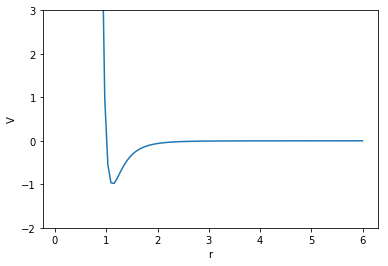

In [3]:
x=np.linspace(0,6, 100)[1:]
y=4*(1/x**12-1/x**6)

plt.plot(x,y)
plt.xlabel('r')
plt.ylabel('V')
plt.ylim(-2, 3)
plt.show()

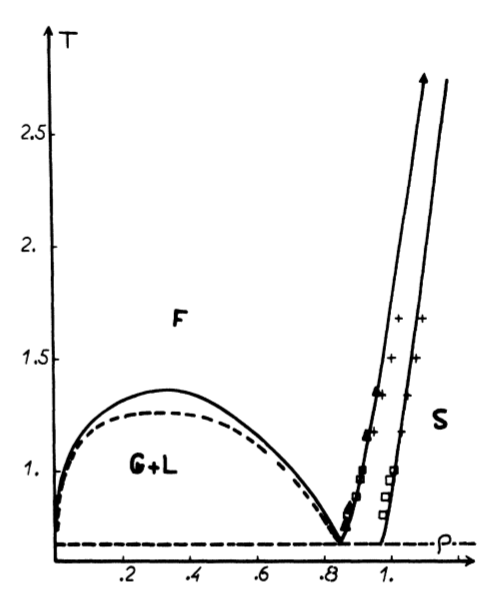

In [5]:
from IPython.display import Image
Image("phasediag.png")

## Utilities

In [86]:
dt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('BINMIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64)])
print(dt.fields.keys())

dict_keys(['BETA', 'MCTIME', 'VIRIAL1', 'DELTA', 'ENERGY', 'N1', 'L', 'ACCEPTANCE', 'ENERGYSQUARE', 'TEMPERATURE', 'DENSITY', 'PRESSURE', 'CV', 'ENERGYERR', 'CVERR', 'N', 'THERMTIME', 'BINMIN', 'BTIME', 'VOLUME', 'PRERR', 'ENERGYTAIL', 'VIRTAIL', 'CUTOFF', 'U', 'TOTENERGY', 'DELTAIN'])


In [87]:
import re
import glob

# Read commented lines of the format '# NAME value' and return a structured array
def get_data(file):
    d = np.zeros([], dtype=dt)
    with open(file) as f:
        for line in f:
            try:
                m = re.match("# (\S+) ([-+]?\d+.\d+e[+-]?\d+)", line)
                d[m.group(1)]=float(m.group(2))
            except:
                try:
                    m = re.match("# (\S+) ([-+]?\d+.\d+)", line)
                    d[m.group(1)]=float(m.group(2))
                except:
                    try:
                        m = re.match("# (\S+) (\d+)", line)
                        d[m.group(1)]=int(m.group(2))
                    except: pass
    return d    

## Read data

In [88]:
file = './data/temp/test1.out'
d=get_data(file)
arr=np.genfromtxt(file, usemask=True, delimiter='\t')
indmax=int(2*d['THERMTIME']/d['BINMIN'])
energyth, virth, rhokth = np.transpose(arr[:indmax])
energybin, virbin =np.transpose(arr[indmax:])[:-1]
d['TEMPERATURE']=1/d['BETA']
d['VOLUME']=d['L']**3
d['N']=d['N1']**3
d['DENSITY'] = (d['N1']/d['L'])**3
d['CUTOFF']=d['L']/2
d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
d['U']=d['ENERGY']+d['ENERGYTAIL']
d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
print(d)

( 0.5,  3600000.,  -6.22672000e-09,  0.09, -3.03802, 5,  6.3,  0.486058,  9.23965,  2.,  0.49990602,  0.86593774,  0.00252112,  0.,  0., 125, 12550, 50, 3600000,  250.047,  0., -0.13394518, -0.26779893,  3.15, -3.17196518, -0.17196518,  0.09)


## Equilibration time

( 0.5,  3600000.,  -6.22672000e-09,  0.09, -3.03802, 5,  6.3,  0.486058,  9.23965,  2.,  0.49990602,  0.86593774,  0.00252112,  0.,  0., 125, 12550, 50, 3600000,  250.047,  0., -0.13394518, -0.26779893,  3.15, -3.17196518, -0.17196518,  0.09)


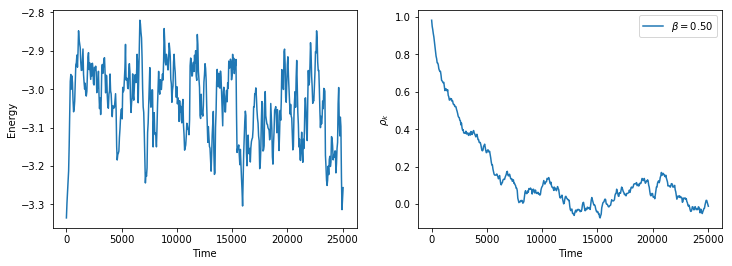

In [89]:
f, axarr = plt.subplots(1,2,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].plot(d['BINMIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
axarr[1].plot(d['BINMIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('Energy')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel(r'$\rho_k$')
print(d)
    
handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.show()

## Error bars

### Correlation time
Block technique: we divide the simulation (total number of steps $N_{steps}$) into $k$ blocks of length $t_B$ ($N_{steps}=k \cdot t_B$). We compute the average quantity over each bin $x_{B_i}$. The sample average of $\{x_{B_i}\}$ is $\bar{x}$, so, if the binned quantities are independent variables, the following is an estimator of the variance of $\bar{x}$

\begin{equation}
s^2=\frac{1}{k(k-1)}\sum_{i=1}^k (x_{B_j}-\bar{x})^2.
\end{equation}


When the size of the blocks is much larger than correlation time, $s^2$ approaches the constant value $\sigma^2_{\bar{x}}$.

### Jackknife estimate of error bars for specific heat
We want to evaluate the error of the quantity $x=\bar{E^2}-\bar{E}^2$ (where the $E_i$ are all independent, i.e. we sample after a time much longer than correlation time). We cannot simply deduce it from the errors of $\bar{E^2}$ and $\bar{E}$ because they are correlated stocastic variables. We apply jackknife technique: $c_i^J$ is obtained excluding $E_i$ from the sample.
\begin{equation}
x_i^J=\frac{N\bar{E^2}-E_i^2}{N-1}-\left[\frac{N\bar{E}-E_i}{N-1}\right]^2
\end{equation}

The error according to jackknife technique is given by
\begin{equation}
\delta x =\sqrt{\frac{1}{N-1}\sum_i (x_i^J-\bar{x^J})^2}
\end{equation}

Calculations yield
\begin{equation}
\bar{x^J}=\sum_i x_i^J =\frac{N(N-2)}{(N-1)^2}(\bar{E^2}-\bar{E}^2)
\end{equation}

\begin{equation}
\delta x^2 =\frac{N^3}{(N-1)^5}(8\bar{E^2}\bar{E}^2+\bar{E^4}-{\bar{E^2}}^2-4\bar{E}\bar{E^3}-4\bar{E}^4)
\end{equation}


In [90]:
def jk_varvar(arr):
    arr1=np.mean(arr)
    arr2=np.mean(arr**2)
    arr3=np.mean(arr**3)
    arr4=np.mean(arr**4)
    return (8*arr2*arr1**2+arr4-arr2**2-4*arr1*arr3-4*arr1**4)*len(arr)**2/(len(arr)-1)**3/(len(arr)-2)


def bintechnique(arr, binning):
    binnum=int(len(arr)/binning)
    red_arr = np.reshape(arr, (binning, binnum), order='F').mean(axis=0)
    return np.var(red_arr, ddof=1)/binnum, np.sqrt(jk_varvar(red_arr)/(binnum-1))

npbintec=np.vectorize(bintechnique, signature='(n),()->(),()')

In [91]:
bins = np.array([i for i in range(1,1000) if int(d['BTIME']/d['BINMIN'])%i==0])

resen=npbintec(energybin, bins)
respr=npbintec(energybin, bins)
d['ENERGYERR']=np.sqrt(np.mean(res[0][-8:])*d['BTIME']/d['MCTIME'])
d['CVERR']=np.mean(res[1][-8:])*d['BTIME']/d['MCTIME']
print(d['ENERGYERR'], d['CVERR'])

0.0019520987670691968 5.782242521172236e-07


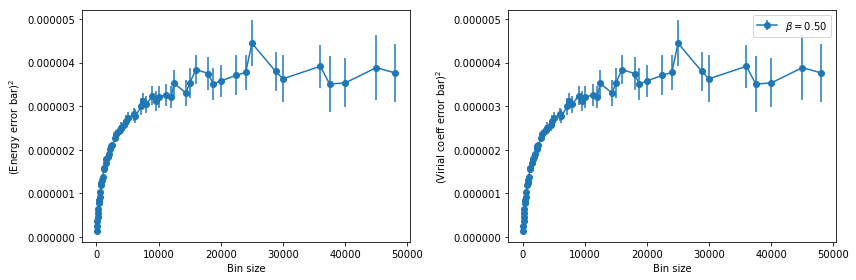

In [92]:
f, axarr = plt.subplots(1,2,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].errorbar(bins*d['BINMIN'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
axarr[1].errorbar(bins*d['BINMIN'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Bin size')
axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_xlabel('Bin size')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
    
handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.tight_layout()
plt.show()

# Analysis

0.34998772570296766 2.994011976047904 -2.0437046400600765 1.0019114884420084 0.0021856924835118377 0.0007649655413903792
0.34998772570296766 2.5 -2.1288046400600766 0.829013434543436 0.0019578851368613932 0.0006852357662377626
0.34998772570296766 1.968503937007874 -2.2469046400600763 0.6429961323398413 0.004464872025304298 0.0015626504056910542
0.34998772570296766 1.7006802721088436 -2.3103546400600763 0.5492611862461179 0.002508598727089603 0.0008779787631954497
0.34998772570296766 1.4492753623188408 -2.3993046400600764 0.4612725956370321 0.005692752938796371 0.0019923936540382275
0.34998772570296766 1.2004801920768309 -2.5341546400600765 0.37419735750517874 0.010329208284149814 0.0036150961156818464


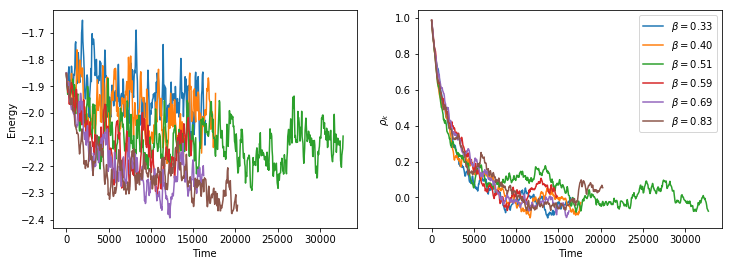

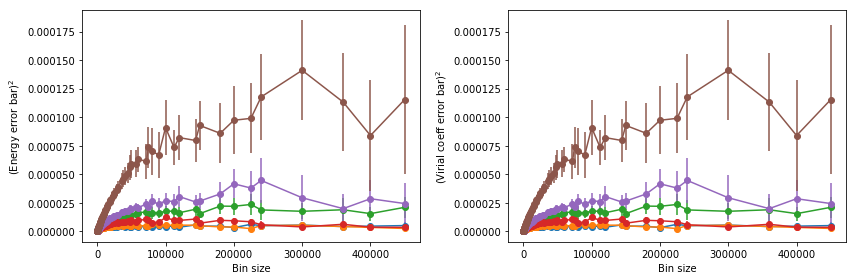

In [98]:
fth, axarrth = plt.subplots(1,2,figsize=(12,4))
feb, axarreb = plt.subplots(1,2,figsize=(12,4))

dataset=np.empty(0, dtype=dt)

for file in glob.glob('./data/run1/*.out'):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['BINMIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, virbin =np.transpose(arr[indmax:])[:-1]
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    bins = np.array([i for i in range(1,10000) if int(d['BTIME']/d['BINMIN'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(energybin, bins)
    d['ENERGYERR']=np.sqrt(np.mean(resen[0][-8:])*d['BTIME']/d['MCTIME'])
    d['CVERR']=np.mean(resen[1][-8:])*d['BTIME']/d['MCTIME']
    d['PRERR']=np.sqrt(np.mean(respr[0][-8:])*d['BTIME']/d['MCTIME'])*d['DENSITY']
    axarrth[0].plot(d['BINMIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
    axarrth[1].plot(d['BINMIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[0].errorbar(bins*d['BINMIN'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[1].errorbar(bins*d['BINMIN'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
    dataset=np.append(dataset, d)
    print(d['DENSITY'], d['TEMPERATURE'], d['U'], d['PRESSURE'], d['ENERGYERR'], d['PRERR'])
   
axarrth[0].set_xlabel('Time')
axarrth[0].set_ylabel('Energy')
axarrth[1].set_xlabel('Time')
axarrth[1].set_ylabel(r'$\rho_k$')
handlesth, labelsth = axarrth[1].get_legend_handles_labels()
labelsth, handlesth = zip(*sorted(zip(labelsth, handlesth), key=lambda t: t[0]))
axarrth[1].legend(handlesth, labelsth)    
    
axarreb[0].set_xlabel('Bin size')
axarreb[0].set_ylabel(r'(Energy error bar$)^2$')
axarreb[1].set_xlabel('Bin size')
axarreb[1].set_ylabel(r'(Virial coeff error bar$)^2$')   
handleseb, labelseb = axarreb[1].get_legend_handles_labels()
labelseb, handleseb = zip(*sorted(zip(labelseb, handleseb), key=lambda t: t[0]))
axarr[1].legend(handleseb, labelseb)
    
plt.tight_layout()
plt.show()

## Comparison to literature

In [27]:
nictab=np.loadtxt('./nicolastab.dat', unpack=True)
N1=5
for counter, el in enumerate(zip(nictab[0]**(-1/3)*N1, 1/nictab[1])):
    print("N1      5\nL       %.4f\nDELTAIN 0.09\nBETA    %.4f\nMCTIME  3600000\
    \nBTIME   3600000\nBINMIN  50\n" % el)

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.3344
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.4000
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.5076
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.5882
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.6897
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       7.0949
DELTAIN 0.09
BETA    0.8333
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       6.5248
DELTAIN 0.09
BETA    0.3390
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       6.5248
DELTAIN 0.09
BETA    0.3861
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       6.5248
DELTAIN 0.09
BETA    0.5076
MCTIME  3600000    
BTIME   3600000
BINMIN  50

N1      5
L       6.5248
DELTAIN 0.09
BETA    0.5882
MCTIME  3600000    
BTIME   3600000
BI